# Getting the most solar power for your dollar
## Model development
### Zachary Brown

I've loaded, cleaned, engineered, and split the dataset I'm using to determine how to optimize cost efficiency for a residential solar panel installation. Now I will screen a range of regression models to identify which gives the best results and refine it as best I can.

I'll start by loading in my X_train and y_train sets so that I can begin training some models.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')
from sklearn.model_selection import train_test_split

In [2]:
print(os.getcwd())
os.chdir(r"..\data\processed")
print(os.getcwd())

C:\Users\Zjbro\OneDrive\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\Zjbro\OneDrive\Documents\GitHub\Solar-Panel-Capstone\data\processed


In [3]:
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_train.head()

,system_size_dc,total_installed_price,rebate_or_grant,expansion_system,multiple_phase_system,tracking,ground_mounted,third_party_owned,self_installed,azimuth_1,...,module_model_1_missing,module_model_1_not_missing,solaredge_technologies,enphase_energy,inverter_manufacturer_1_missing,inverter_manufacturer_1_other,inverter_model_1_missing,iq7,se3,inverter_model_1_other
1480676,2.80,10472.0,0.0,0,0,0,0,1,0,127.0,...,0,1,0,1,0,0,0,0,0,1
1541293,7.44,22904.3,0.0,0,0,0,0,1,0,258.0,...,0,1,0,1,0,0,0,1,0,0
422316,9.60,3000.0,0.0,0,0,0,0,1,0,180.0,...,0,1,0,1,0,0,0,1,0,0
275862,2.56,8200.0,0.0,0,0,0,0,1,0,180.0,...,0,1,0,1,0,0,0,0,0,1
416176,4.10,36930.0,0.0,0,0,0,0,0,0,180.0,...,0,1,0,0,0,0,0,0,0,1


In [4]:
X_train.shape, y_train.shape

((156192, 89), (156192, 1))

In [5]:
X_train.columns

Index(['system_size_dc', 'total_installed_price', 'rebate_or_grant',
       'expansion_system', 'multiple_phase_system', 'tracking',
       'ground_mounted', 'third_party_owned', 'self_installed', 'azimuth_1',
       'tilt_1', 'module_quantity_1', 'additional_modules', 'bipv_module_1',
       'bifacial_module_1', 'nameplate_capacity_module_1',
       'efficiency_module_1', 'inverter_quantity_1', 'additional_inverters',
       'micro_inverter_1', 'solar_storage_hybrid_inverter_1',
       'built_in_meter_inverter_1', 'dc_optimizer', 'inverter_loading_ratio',
       'year', 'month', 'state_AZ', 'state_CA', 'state_CO', 'state_CT',
       'state_DE', 'state_FL', 'state_MA', 'state_MD', 'state_MN', 'state_NH',
       'state_NM', 'state_NY', 'state_RI', 'state_TX', 'state_UT', 'state_WI',
       'technology_module_1_-1', 'technology_module_1_CIGS',
       'technology_module_1_CdTe', 'technology_module_1_Mono',
       'technology_module_1_Multi-c-Si', 'technology_module_1_Poly',
       'techno

First I'm going to train a few dummy regression models to see how they performs and to set a benchmark of what I should consider a useful model. Since there isn't any reason large outliers should be extra harshly penalized, I'm going to rank the models based on mean absolute error (MAE), while plotting both MAE and root mean squared error (RMSE).

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.fit_transform(y_train)

x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.8)
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((31238, 89), (124954, 89), (31238, 1), (124954, 1))

In [7]:
# Reshape y_train for model fitting
y_tr = y_tr.values.ravel()
y_te = y_te.values.ravel()

In [100]:
# Using the mean of the training set
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(x_tr, y_tr)
y_pred = dummy_mean.predict(x_te)
train_scores = {'Mean Dummy Regressor' : mean_absolute_error(y_te, y_pred)}
print(mean_absolute_error(y_te, y_pred))

1107.7691453592365


In [101]:
# Using the median of the training set
dummy_median = DummyRegressor(strategy="median")
dummy_median.fit(x_tr, y_tr)
y_pred = dummy_median.predict(x_te)
train_scores['Median Dummy Regressor'] = mean_absolute_error(y_te, y_pred)
print(mean_absolute_error(y_te, y_pred))

1085.3282386270307


In [102]:
# One final dummy regressor using the 25th quantile of the training set
dummy_quantile = DummyRegressor(strategy="quantile", quantile = 0.25)
dummy_quantile.fit(x_tr, y_tr)
y_pred = dummy_quantile.predict(x_te)
train_scores['25th Quantile Dummy Regressor'] = mean_absolute_error(y_te, y_pred)
print(mean_absolute_error(y_te, y_pred))

1254.8328650659744


Now that I have some base RMSE values that give me a cutoff for whether my models are effective or not, I'll begin with an ordinary least squares model.

In [103]:
ols = LinearRegression()
ols.fit(x_tr, y_tr)
y_pred = ols.predict(x_te)
train_scores['OLS'] = mean_absolute_error(y_te, y_pred)
print(mean_absolute_error(y_te, y_pred))

773.8467551456639


OLS shows a relatively modest improvement over the dummy regressors from 43 million to 12. I want to check the coefficients to get a feel for how many there are, and their magnitudes.

In [104]:
ols.coef_

array([-1.01593723e+02,  1.49655652e-01, -1.59460069e-01,  8.33711321e+02,
       -2.33110092e+01,  5.17524050e+02, -8.87399920e+02,  1.53249213e+01,
        2.55022968e+02, -8.17324759e-01,  3.67852174e+00, -9.55595293e+01,
       -1.82499014e+03,  1.10738931e+04,  1.73321461e+02, -7.49548342e+00,
       -1.94320049e+03, -5.45351519e+01,  6.53832132e+03,  1.11482630e+03,
        2.01361289e+02,  2.91595666e+02,  3.83668648e+02, -1.16216563e+03,
       -3.55022571e+02, -4.60315723e+00, -5.09555278e+02,  1.69085517e+02,
        4.67018207e+02,  9.44480238e+01, -1.33256587e+02, -8.93923027e+02,
        9.10722293e+00, -5.76847823e+02, -5.17222545e+02, -3.23865637e+02,
       -5.84350346e-10,  5.18619897e+02,  5.26513047e+02,  6.30970609e+02,
        3.78270236e+02,  1.60638137e+02,  2.06870979e+02, -1.65232450e-09,
        3.09250936e-09,  1.22062379e+03,  1.14348083e+03,  5.02856250e+02,
       -3.07383185e+03, -8.33664463e+02, -8.52376442e+02,  3.32706327e+02,
        1.69085520e+02,  

As expected, OLS produces a huge number of coefficients. I'll take a look at ridge regression to see if it will generate a better model with fewer coefficients.

In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [115]:
parameters = {'alpha': sp_randFloat(0.00001,100)}
ridge = Ridge()
ridge_reg = RandomizedSearchCV(ridge, parameters,scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                               refit='neg_mean_absolute_error', n_iter=60, cv=5)
random_ridge = ridge_reg.fit(x_tr, y_tr)
random_ridge.best_params_

{'alpha': 65.866216317069}

In [116]:
random_ridge_results = pd.DataFrame(random_ridge.cv_results_)
random_ridge_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error'],
      dtype='object')

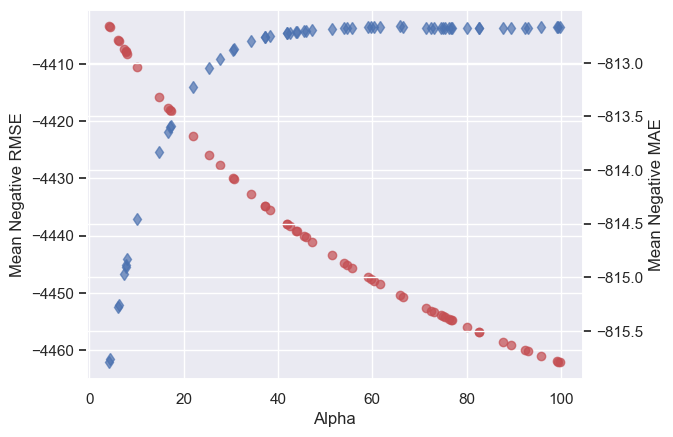

In [117]:
fig, ax = plt.subplots()
ax.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2 = ax.twinx()
ax2.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)
ax2.set_ylabel('Mean Negative MAE')
plt.show()

Now that I have an idea of where the optimal alpha value lies for the ridge regression I'll fit an optimized ridge to the train data and add the RMSE to my collection of scores.

In [118]:
ridge=Ridge(alpha=random_ridge.best_params_['alpha'])
ridge.fit(x_tr, y_tr)
y_pred = ridge.predict(x_te)
train_scores['Ridge'] = mean_absolute_error(y_te, y_pred)
print(mean_absolute_error(y_te, y_pred))

764.9820161540563


So ridge regression performs almost the exact same as OLS, good to know. Next I'll identify the best alpha for a lasso regression to compare that against the OLS and ridge models.

In [110]:
parameters = {'alpha': sp_randFloat(0.00001,20)}
lasso = linear_model.Lasso()
rand = RandomizedSearchCV(lasso, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                          refit='neg_mean_absolute_error', n_iter=60, cv=5, random_state=0)
rand_lasso = rand.fit(x_tr, y_tr)
rand_lasso.best_params_

{'alpha': 4.207661221476817}

In [111]:
rand_lasso_params = pd.DataFrame(rand_lasso.cv_results_)
rand_lasso_params.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,...,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.259725,0.125234,0.006221,0.000724,10.97628,{'alpha': 10.976280078546495},-2349.347754,-2498.376337,-13012.993560,-1463.512286,...,4296.472068,31,-800.304787,-757.376545,-943.053507,-734.033407,-854.221759,-817.798001,74.818319,31
1,0.293462,0.040011,0.005027,0.001626,14.303797,{'alpha': 14.30379732744839},-2375.048621,-2552.594398,-13053.118515,-1474.778849,...,4302.843326,46,-805.906649,-762.854709,-950.814880,-741.599215,-865.124199,-825.259930,75.658815,46
2,0.258203,0.099014,0.005935,0.000724,12.055278,{'alpha': 12.055277521432878},-2358.457236,-2516.346202,-13026.711993,-1467.107237,...,4298.724801,35,-802.569995,-759.228673,-945.575368,-736.452990,-857.554302,-820.276266,75.041561,35
3,0.273597,0.120930,0.006250,0.000614,10.897674,{'alpha': 10.897673659937936},-2348.642715,-2497.083507,-13011.920989,-1463.279756,...,4296.276613,30,-800.096803,-757.238950,-942.850115,-733.878167,-854.002413,-817.613290,74.795574,30
4,0.240928,0.130258,0.004896,0.001194,8.473106,{'alpha': 8.473105986778094},-2327.273474,-2453.162139,-12975.866468,-1457.539999,...,4289.269663,21,-794.404179,-751.263749,-935.222204,-730.237552,-848.330268,-811.891590,73.738923,18


C:\Users\Zachary Brown\AppData\Local\Temp\ipykernel_3488\687083208.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001FE86A51BE0> has a label of '_child0' which cannot be automatically added to the legend.
  ax.legend(axs, labs, loc=0)
C:\Users\Zachary Brown\AppData\Local\Temp\ipykernel_3488\687083208.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001FE86A83640> has a label of '_child0' which cannot be automatically added to the legend.
  ax.legend(axs, labs, loc=0)


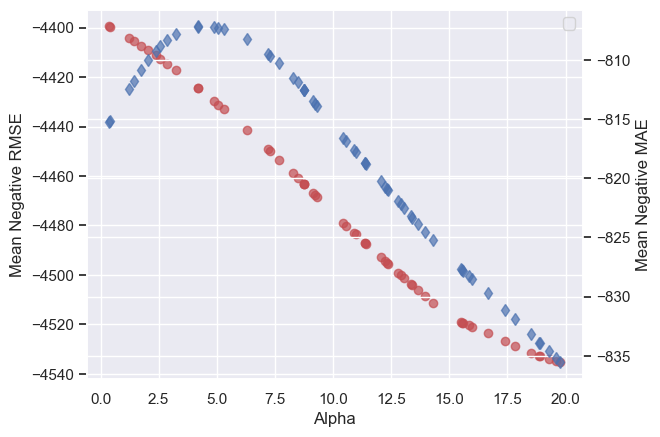

In [112]:
fig, ax = plt.subplots()

a1 = ax.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)

ax2 = ax.twinx()
a2 = ax2.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)

axs = a1+a2
labs = [a.get_label() for a in axs]
ax.legend(axs, labs, loc=0)

ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2.set_ylabel('Mean Negative MAE')

plt.show()

In [113]:
lasso = linear_model.Lasso(alpha=rand_lasso.best_params_['alpha'])
lasso.fit(x_tr, y_tr)
y_pred = lasso.predict(x_te)
train_scores['Lasso'] = mean_absolute_error(y_te, y_pred)
print(mean_absolute_error(y_te, y_pred))

761.8133480624706


Again only a marginal increase relative to ridge and OLS regression. Next I'm going to take a look at random forest and see if that can produce a significant reduction in MAE.

In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [126]:
parameters = {'n_estimators': sp_randInt(10,1000),
             'max_features': sp_randFloat(0.00001, 1.0),
             'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(1000,50000),
             }
forest = RandomForestRegressor(n_jobs=-1, random_state=12)
forest_reg = RandomizedSearchCV(forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_mean_absolute_error', n_iter=60, cv=5, random_state=12)
rand_forest = forest_reg.fit(x_tr, y_tr)
rand_forest.best_params_

{'max_depth': 5,
 'max_features': 0.73253069814195,
 'min_samples_leaf': 1160,
 'n_estimators': 821}

In [127]:
rand_forest_params = pd.DataFrame(rand_forest.cv_results_)
rand_forest_params.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_neg_root_mean_squared_error,...,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.338324,0.009025,0.068287,0.011007,5,0.446232,20709,251,"{'max_depth': 5, 'max_features': 0.44623174456...",-4335.649112,...,9496.834936,54,-1190.445186,-1081.426016,-1478.446077,-1142.609240,-1082.570136,-1195.099331,147.408746,53
1,0.483051,0.005176,0.092841,0.013199,4,0.533749,13108,442,"{'max_depth': 4, 'max_features': 0.53374939338...",-4335.641427,...,9496.878359,37,-1189.809067,-1080.868153,-1478.497419,-1142.535820,-1082.467901,-1194.835672,147.539581,37
2,0.612612,0.040921,0.088129,0.002767,8,0.033974,21109,483,"{'max_depth': 8, 'max_features': 0.03397417126...",-4335.641147,...,9496.913588,22,-1189.778073,-1080.817621,-1478.490932,-1142.015365,-1081.973172,-1194.615033,147.657500,22
3,1.548547,0.248858,0.114852,0.023586,4,0.725964,6194,394,"{'max_depth': 4, 'max_features': 0.72596416111...",-4286.021551,...,9522.420181,12,-1125.999918,-1023.132721,-1415.578889,-1081.285358,-1024.813228,-1134.162023,145.837361,12
4,0.370432,0.028893,0.046990,0.010198,7,0.606093,49397,92,"{'max_depth': 7, 'max_features': 0.60609318435...",-4335.647353,...,9496.881065,51,-1190.322563,-1081.030587,-1478.204430,-1142.523217,-1082.515595,-1194.919278,147.392114,50


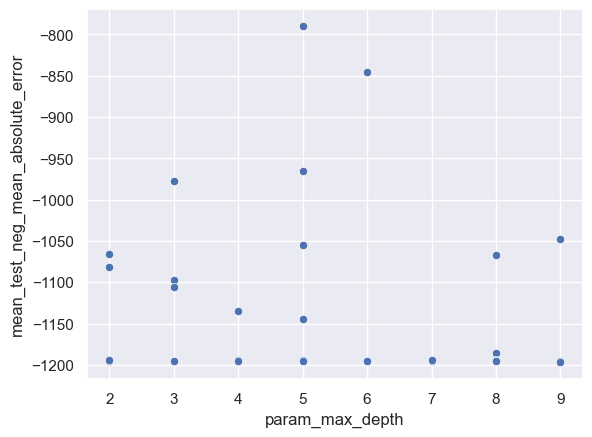

In [128]:
sns.scatterplot(data=rand_forest_params, x='param_max_depth', y='mean_test_neg_mean_absolute_error')
plt.show()

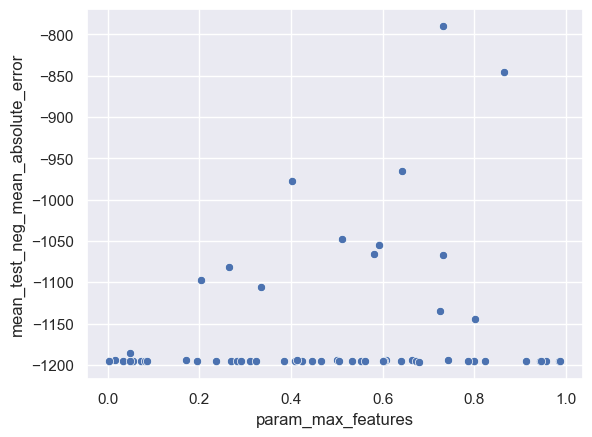

In [129]:
sns.scatterplot(data=rand_forest_params, x='param_max_features', y='mean_test_neg_mean_absolute_error')
plt.show()

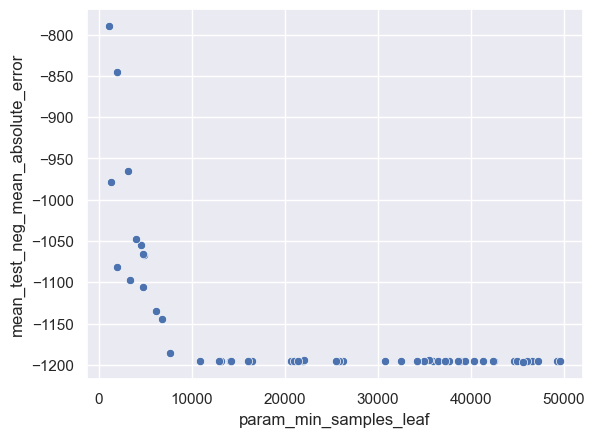

In [130]:
sns.scatterplot(data=rand_forest_params, x='param_min_samples_leaf', y='mean_test_neg_mean_absolute_error')
plt.show()

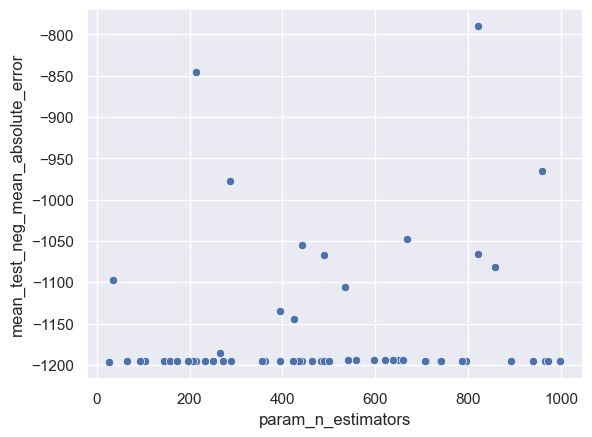

In [131]:
sns.scatterplot(data=rand_forest_params, x='param_n_estimators', y='mean_test_neg_mean_absolute_error')
plt.show()

In [132]:
parameters = {
             'min_samples_leaf': sp_randInt(50,10000)
             }
forest = RandomForestRegressor(n_estimators=rand_forest.best_params_['n_estimators'],\
                               max_features=rand_forest.best_params_['max_features'],\
                               max_depth=rand_forest.best_params_['max_depth'], n_jobs=-1, random_state=12)
forest_reg = RandomizedSearchCV(forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_mean_absolute_error', n_iter=60, cv=5, random_state=12)
random_forest = forest_reg.fit(x_tr, y_tr)
random_forest.best_params_

{'min_samples_leaf': 258}

In [156]:
opt_forest = RandomForestRegressor(n_estimators=rand_forest.best_params_['n_estimators'],\
                                   max_features=rand_forest.best_params_['max_features'],\
                                   min_samples_leaf=random_forest.best_params_['min_samples_leaf'],\
                                   max_depth=rand_forest.best_params_['max_depth'], n_jobs = -1, random_state=12)
opt_forest.fit(x_tr, y_tr)
y_pred = opt_forest.predict(x_te)
train_scores['Random Forest'] = mean_absolute_error(y_te, y_pred)
mean_absolute_error(y_te, y_pred)

680.915890979473

Nice, random forest improved upon the other models by ~80 MAE. I'll take a look at XGBoost next to see if it can improve even further.

In [151]:
from xgboost import XGBRegressor

In [155]:
xgb = XGBRegressor(verbosity = 0)
parameters = {'n_estimators': sp_randInt(10,1000),
             'max_depth': sp_randInt(2,10),
             'eta': sp_randFloat(0.0001,1),
             'colsample_bytree': sp_randFloat(0.2,1)} 
rand_xgb = RandomizedSearchCV(xgb, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_mean_absolute_error', n_iter=60, cv=5, random_state=12)
xgboost = rand_xgb.fit(x_tr, y_tr)
xgboost.best_params_

C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be

C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be

C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be

C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be

C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be

C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be

C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be

C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be

C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be

C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be

C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be

{'colsample_bytree': 0.9784734338593446,
 'eta': 0.1355351345676108,
 'max_depth': 9,
 'n_estimators': 920}

In [159]:
xgb_model = XGBRegressor(n_estimators=xgboost.best_params_['n_estimators'],\
                                   eta=xgboost.best_params_['eta'],\
                                   colsample_bytree=xgboost.best_params_['colsample_bytree'],\
                                   max_depth=xgboost.best_params_['max_depth'])
xgb_model.fit(x_tr, y_tr)
y_pred = xgb_model.predict(x_te)
train_scores['XGBoost'] = mean_absolute_error(y_te, y_pred)
mean_absolute_error(y_te, y_pred)

C:\Users\Zachary Brown\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


55.19166635969185

Wow! XGBoost knocked down the MAE from 680 (with random forest) to 55! Just for some context I'm going to check the range between the 5th and 95th percentiles of the price per KW just to get an idea of how much error \\$55 represents.

In [170]:
print(np.quantile(y_train['price_per_kw'], 0.05))
print(np.quantile(y_train['price_per_kw'], 0.95))

1951.8653068332994
6081.389624328631


Great! 90% of the data lie within a \\$4100 spread, so having an estimate with \\$55 error is pretty good. Let's see if we can get any better with a decision tree.

In [ ]:
from sklearn import tree

d_tree = tree.DecisionTreeRegressor(criterion = 'absolute_error')
parameters = {'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(100,5000)}
rand_tree = RandomizedSearchCV(d_tree, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_mean_absolute_error', n_iter=60, cv=5, random_state=12)
decision_tree = rand_tree.fit(x_tr, y_tr)
decision_tree.best_params_

In [ ]:
decision_tree_model = tree.DecisionTreeRegressor(criterion = 'absolute_error',\
                                            max_depth = decision_tree.best_params_['max_depth'],\
                                            min_samples_leaf = decision_tree.best_params_['min_samples_leaf'])
decision_tree_model.fit(x_tr, y_tr)
y_pred = decision_tree_model.predict(x_te)
train_scores['Decision Tree'] = mean_absolute_error(y_te, y_pred)
mean_absolute_error(y_te, y_pred)

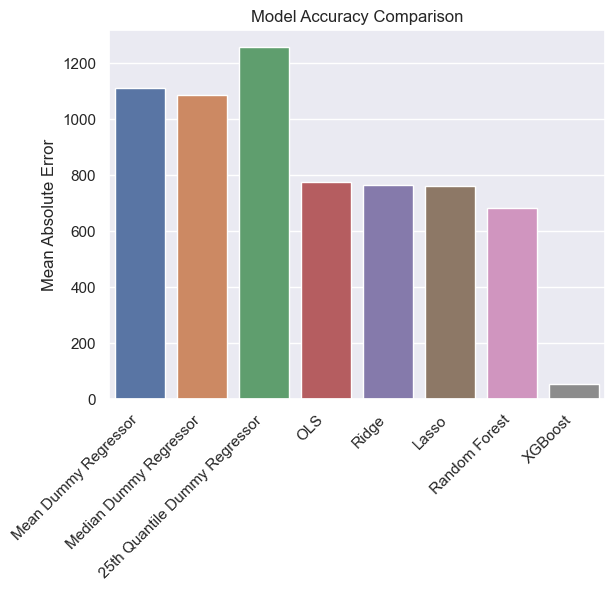

In [160]:
keys = list(train_scores.keys())
vals = [float(train_scores[k]) for k in keys]
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean Absolute Error')
plt.title('Model Accuracy Comparison')
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

neighbors = KNeighborsRegressor()
parameters = {'n_neighbors': sp_randInt(2,50)}
rand_knn = RandomizedSearchCV(neighbors, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_mean_absolute_error', n_iter=60, cv=5, random_state=12)
opt_nn = rand_knn.fit(x_tr, y_tr)
opt_nn.best_params_

In [ ]:
knn_opt = KNeighborsRegressor(n_neighbors = opt_nn.best_params_['n_neighbors'])
knn_opt.fit(x_tr, y_tr)
y_pred = knn_opt.predict(x_te)
train_scores['KNN'] = mean_absolute_error(y_te, y_pred)
mean_absolute_error(y_te, y_pred)

In [ ]:
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'mae')
parameters = {'num_leaves': sp_randInt(10,1000),
              'min_data_in_leaf': sp_randInt(10,10000),
              'max_depth': sp_randInt(2,10),
              'learning_rate': sp_randFloat(0.001,1)}
rand_lgbm = RandomizedSearchCV(lgb, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_mean_absolute_error', n_iter=60, cv=5, random_state=12)
opt_lgbm = rand_lgb.fit(x_tr, y_tr)
opt_lgbm.best_params_

In [ ]:
lgbm_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'mae', num_leaves = opt_lgbm.best_params_['num_leaves'],\
                             min_data_in_leaf = opt_lgbm.best_params_['min_data_in_leaf'],\
                             max_depth = opt_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_lgbm.best_params_['learning_rate'])
lgbm_opt.fit(x_tr, y_tr)
y_pred = lgbm_opt.predict(x_te)
train_scores['Light GBM'] = mean_absolute_error(y_te, y_pred)
mean_absolute_error(y_te, y_pred)

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(random_state=12)
parameters = {}
rand_mlp = RandomizedSearchCV(mlp, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_mean_absolute_error', n_iter=60, cv=5, random_state=12)
opt_mlp = rand_mlp.fit(x_tr, y_tr)
opt_mlp.best_params_

In [ ]:
mlp_opt = MLPRegressor()
mlp_opt.fit(x_tr, y_tr)
y_pred = mlp_opt.predict(x_te)
train_scores['MLP'] = mean_absolute_error(y_te, y_pred)
mean_absolute_error(y_te, y_pred)